In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import periodogram
from scipy.stats.mstats import normaltest
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
from livelossplot import PlotLossesKeras
from warnings import simplefilter
simplefilter("ignore")
# Set Matplotlib defaults
#plt.style.use("seaborn-whitegrid")
plt.style.use('ggplot')
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

In [2]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax, palette=palette, legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", size=14, va="center")
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)", 
                        "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}", prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

# define train test split function
def train_test_datasets(df, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:, col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, y_train = np.split(train, [-y_len], axis=1)

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)
        y_train, y_test = np.split(y_train, [-rows*test_loops], axis=0)
    else: # No test set: X_test is used to generate the future forecast
        X_test = D[:, -x_len:]     
        y_test = np.full((X_test.shape[0], y_len), np.nan) #Dummy value
    
    # Formatting required for scikit-learn
    if y_len == 1: 
        y_train = y_train.ravel()
        y_test = y_test.ravel()  
        
    return X_train, y_train, X_test, y_test

# define score metric function
def kpi(y_train, y_train_pred, y_test, y_test_pred, name=''):
    df = pd.DataFrame(columns = ['MAE','RMSE', 'Bias', 'MAE_pct', 'RMSE_pct', 'r2_score'], index=['Train','Test'])
    df.index.name = name
    df.loc['Train','MAE_pct'] = 100*np.mean(abs(y_train - y_train_pred))/np.mean(y_train)
    df.loc['Train','RMSE_pct'] = 100*np.sqrt(np.mean((y_train - y_train_pred)**2))/np.mean(y_train)
    df.loc['Train','Bias'] = 100*np.mean((y_train - y_train_pred))/np.mean(y_train)
    df.loc['Train','r2_score'] =  r2_score(y_train, y_train_pred)
    df.loc['Train','MAE'] = mean_absolute_error(y_train, y_train_pred)
    df.loc['Train','RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
    df.loc['Test','MAE_pct'] = 100*np.mean(abs(y_test - y_test_pred))/np.mean(y_test) 
    df.loc['Test','RMSE_pct'] = 100*np.sqrt(np.mean((y_test - y_test_pred)**2))/np.mean(y_test)
    df.loc['Test','Bias'] = 100*np.mean((y_test - y_test_pred))/np.mean(y_test)
    df.loc['Test','r2_score'] =  r2_score(y_test, y_test_pred)
    df.loc['Test','MAE'] = mean_absolute_error(y_test, y_test_pred)
    df.loc['Test','RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
    df = df.astype(float).round(2) #Round number for display
    print(df)

In [3]:
data = pd.read_csv('train.csv')
data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
data.date = pd.to_datetime(data.date)

In [6]:
dframe = pd.pivot_table(data=data, values='sales', index='date', columns='family', aggfunc='sum', fill_value=0)
dframe.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,0,2,810,0,180.58900,0,186,143,71.09000,...,0,110.801000,25,0,0,42.637000,37.847000,0.0,0,0.000000
2013-01-02,255,0,207,72092,0,26246.31900,0,74629,23381,15754.50000,...,0,20871.464028,17204,0,0,13975.884938,5338.111976,0.0,0,1526.750002
2013-01-03,161,0,125,52105,0,18456.48002,0,55893,18001,11172.45500,...,0,16597.398113,12568,0,0,10674.393983,3591.388005,0.0,0,1094.310994
2013-01-04,169,0,133,54167,0,16721.96901,0,52064,18148,10143.20900,...,0,21625.963055,11303,0,0,10772.515038,4472.965990,0.0,0,1293.120995
2013-01-05,342,0,191,77818,0,22367.76108,0,70128,23082,13734.94501,...,0,20879.091050,16819,0,0,13475.009055,5830.073020,0.0,0,1245.637004


In [8]:
dframe.shape

(1684, 33)

In [9]:
# check missing dates

index = pd.date_range(start=dframe.index.min(), end='2017-08-15', freq='D')
print('number of missing dates = ', index.shape[0] - dframe.shape[0])

number of missing dates =  4


In [10]:
index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [11]:
dframe = dframe.reindex(index)
dframe.tail()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
2017-08-11,441.0,7.0,351.0,189111.0,0.0,28204.48600,870.0,55682.0,44909.0,18680.488004,...,500.0,26944.092010,15978.0,587.0,654.0,25318.297990,5199.494021,118738.14300,3523.0,1272.615997
2017-08-12,403.0,3.0,369.0,182318.0,0.0,27403.54800,849.0,57935.0,42854.0,15689.893010,...,483.0,17775.650112,15903.0,508.0,712.0,19134.510058,4573.465992,111788.35090,3644.0,1028.030006
2017-08-13,481.0,9.0,433.0,202354.0,1.0,33262.75700,544.0,61757.0,50112.0,17593.274020,...,469.0,18633.015039,18188.0,541.0,741.0,20509.265004,4941.509018,125923.80240,3718.0,1118.047000
2017-08-14,292.0,9.0,337.0,174832.0,0.0,28002.45700,594.0,55032.0,43050.0,14662.741000,...,457.0,16975.686040,15077.0,417.0,500.0,18597.508060,4647.375002,115257.59598,2826.0,970.679999
2017-08-15,337.0,8.0,339.0,170773.0,0.0,29158.19502,597.0,58474.0,40707.0,14935.453000,...,461.0,17928.170944,14787.0,364.0,592.0,17586.709986,4641.522980,125108.97100,2530.0,970.177005


In [12]:
dframe.isnull().sum()

family
AUTOMOTIVE                    4
BABY CARE                     4
BEAUTY                        4
BEVERAGES                     4
BOOKS                         4
BREAD/BAKERY                  4
CELEBRATION                   4
CLEANING                      4
DAIRY                         4
DELI                          4
EGGS                          4
FROZEN FOODS                  4
GROCERY I                     4
GROCERY II                    4
HARDWARE                      4
HOME AND KITCHEN I            4
HOME AND KITCHEN II           4
HOME APPLIANCES               4
HOME CARE                     4
LADIESWEAR                    4
LAWN AND GARDEN               4
LINGERIE                      4
LIQUOR,WINE,BEER              4
MAGAZINES                     4
MEATS                         4
PERSONAL CARE                 4
PET SUPPLIES                  4
PLAYERS AND ELECTRONICS       4
POULTRY                       4
PREPARED FOODS                4
PRODUCE                       4
S

In [13]:
dframe.fillna(0, inplace=True)
dframe.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.58900,0.0,186.0,143.0,71.09000,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.0,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.31900,0.0,74629.0,23381.0,15754.50000,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.0,0.0,1526.750002
2013-01-03,161.0,0.0,125.0,52105.0,0.0,18456.48002,0.0,55893.0,18001.0,11172.45500,...,0.0,16597.398113,12568.0,0.0,0.0,10674.393983,3591.388005,0.0,0.0,1094.310994
2013-01-04,169.0,0.0,133.0,54167.0,0.0,16721.96901,0.0,52064.0,18148.0,10143.20900,...,0.0,21625.963055,11303.0,0.0,0.0,10772.515038,4472.965990,0.0,0.0,1293.120995
2013-01-05,342.0,0.0,191.0,77818.0,0.0,22367.76108,0.0,70128.0,23082.0,13734.94501,...,0.0,20879.091050,16819.0,0.0,0.0,13475.009055,5830.073020,0.0,0.0,1245.637004


In [14]:
dframe.isnull().sum()

family
AUTOMOTIVE                    0
BABY CARE                     0
BEAUTY                        0
BEVERAGES                     0
BOOKS                         0
BREAD/BAKERY                  0
CELEBRATION                   0
CLEANING                      0
DAIRY                         0
DELI                          0
EGGS                          0
FROZEN FOODS                  0
GROCERY I                     0
GROCERY II                    0
HARDWARE                      0
HOME AND KITCHEN I            0
HOME AND KITCHEN II           0
HOME APPLIANCES               0
HOME CARE                     0
LADIESWEAR                    0
LAWN AND GARDEN               0
LINGERIE                      0
LIQUOR,WINE,BEER              0
MAGAZINES                     0
MEATS                         0
PERSONAL CARE                 0
PET SUPPLIES                  0
PLAYERS AND ELECTRONICS       0
POULTRY                       0
PREPARED FOODS                0
PRODUCE                       0
S

In [15]:
df = dframe.T
df.head()

,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
family,,,,,,,,,,,,,,,,,,,,,
AUTOMOTIVE,0.0,255.0,161.0,169.0,342.0,360.0,189.0,229.0,164.0,164.0,...,583.0,355.0,327.0,314.0,313.0,441.0,403.0,481.0,292.0,337.0
BABY CARE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,14.0,5.0,10.0,5.0,7.0,3.0,9.0,9.0,8.0
BEAUTY,2.0,207.0,125.0,133.0,191.0,265.0,124.0,116.0,104.0,96.0,...,558.0,317.0,328.0,315.0,309.0,351.0,369.0,433.0,337.0,339.0
BEVERAGES,810.0,72092.0,52105.0,54167.0,77818.0,86184.0,51619.0,46941.0,47910.0,42390.0,...,250784.0,179419.0,160636.0,153010.0,156449.0,189111.0,182318.0,202354.0,174832.0,170773.0
BOOKS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=365, y_len=1, test_loops=150)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38709, 365), (4950, 365), (38709,), (4950,))

In [17]:
# Linear Regression as first model to compare

reg = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(1)), 
                ('LinearRegression', LinearRegression())]) # Create a linear regression object


reg.fit(X_train, y_train) # Fit it to the training data

# Create two predictions for the training and test sets
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Regression')

                MAE     RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Regression                                                     
Train       2192.28  7563.83 -0.00    10.55     36.40      0.98
Test        2984.20  8990.38 -0.66    11.46     34.54      0.98


In [18]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=365, y_len=1, test_loops=0) #use 252 for 1day, 253 for second day

reg = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(1)), 
                ('LinearRegression', LinearRegression())]) # Create a linear regression object

reg.fit(X_train,y_train) # Fit it to the training data

reg_forecast = pd.DataFrame(data=reg.predict(X_test), index=df.index)#, columns=['21-02-2022', '22-02-2022'])
reg_forecast.head()

,0
family,
AUTOMOTIVE,398.222656
BABY CARE,72.894531
BEAUTY,421.585938
BEVERAGES,157857.492188
BOOKS,52.519531


In [20]:
# use Random Forest with default parameters

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=7, y_len=1, test_loops=150)

forest = Pipeline([('scaler', MinMaxScaler()), ('Forest', RandomForestRegressor())])

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Forest')

            MAE     RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Forest                                                     
Train    684.12  3022.21 -0.03     3.67     16.21      1.00
Test    2493.39  8960.10  0.66     9.58     34.42      0.98


### LSTM

In [21]:
x_len = 7
y_len = 1
n_features = 1

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=x_len, y_len=y_len, test_loops=150)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_train = y_train.reshape(X_train.shape[0], y_len)
y_test = y_test.reshape(X_test.shape[0], y_len)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50523, 7, 1), (4950, 7, 1), (50523, 1), (4950, 1))

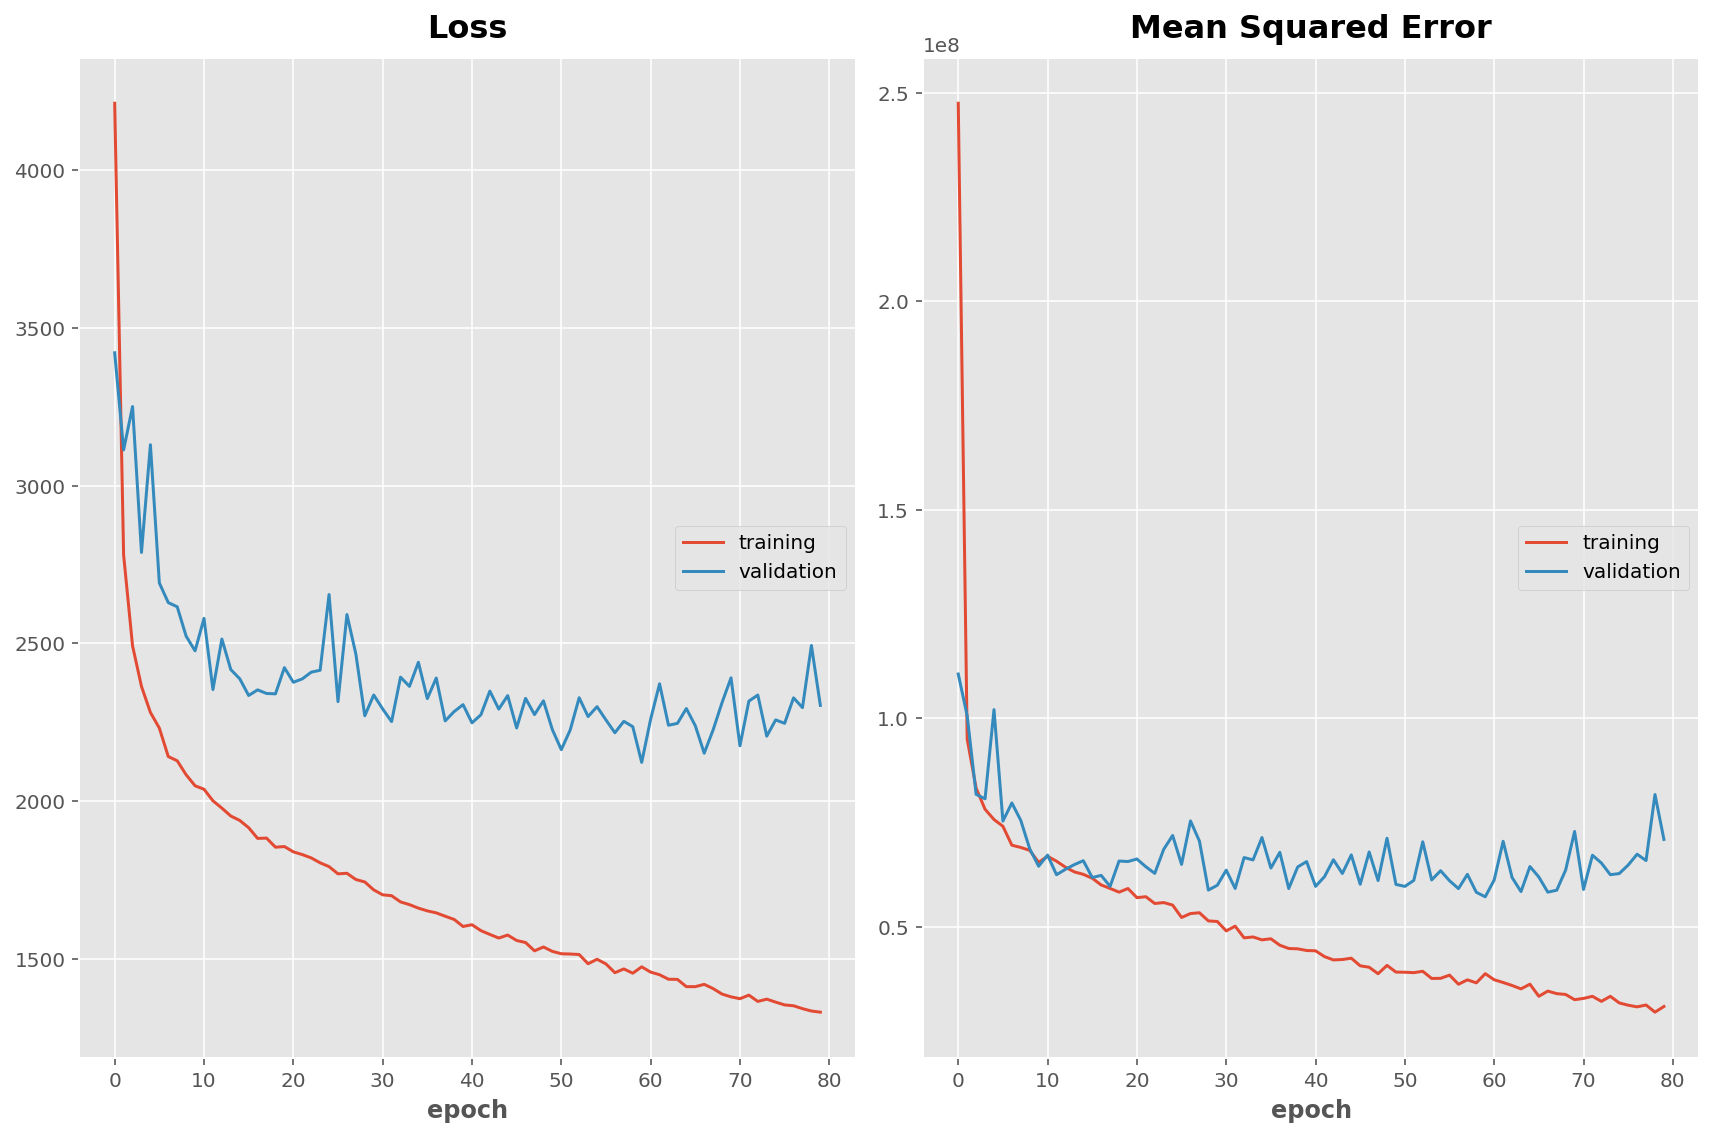

Loss
	training         	 (min: 1330.752, max: 4212.436, cur: 1330.752)
	validation       	 (min: 2122.604, max: 3421.258, cur: 2303.420)
Mean Squared Error
	training         	 (min: 29506994.000, max: 247435360.000, cur: 30862612.000)
	validation       	 (min: 57162392.000, max: 110578752.000, cur: 70923736.000)
1579/1579 [==============================] - 22s 14ms/step - loss: 1330.7518 - mse: 30862612.0000 - val_loss: 2303.4202 - val_mse: 70923736.0000


In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=96, 
                                                           kernel_size=5, 
                                                           strides=1, 
                                                           padding='causal', 
                                                           activation='relu', 
                                                           input_shape=(x_len, n_features)), 
                                    tf.keras.layers.LSTM(100, return_sequences=True), 
                                    tf.keras.layers.LSTM(100), 
                                    tf.keras.layers.Dense(30), 
                                    tf.keras.layers.Dense(10), 
                                    tf.keras.layers.Dense(y_len),
                                    tf.keras.layers.Lambda(lambda x: x * 400)])


#model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss=tf.keras.losses.Huber() ,optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, 
                    callbacks=[PlotLossesKeras(), callback], verbose=1)

In [23]:
y_train_pred = model.predict(X_train) 
y_test_pred = model.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='LSTM')

           MAE     RMSE  Bias  MAE_pct  RMSE_pct  r2_score
LSTM                                                      
Train  1291.66  5352.72  1.55     6.93     28.70      0.99
Test   2303.92  8421.62  2.17     8.85     32.35      0.98


In [24]:
# Forecasting

x_len = 7
y_len = 1
n_features = 1

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=x_len, y_len=y_len, test_loops=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_train = y_train.reshape(X_train.shape[0], y_len)
y_test = y_test.reshape(X_test.shape[0], y_len)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55473, 7, 1), (33, 7, 1), (55473, 1), (33, 1))

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=96, 
                                                           kernel_size=5, 
                                                           strides=1, 
                                                           padding='causal', 
                                                           activation='relu', 
                                                           input_shape=(x_len, n_features)), 
                                    tf.keras.layers.LSTM(100, return_sequences=True), 
                                    tf.keras.layers.LSTM(100), 
                                    tf.keras.layers.Dense(30), 
                                    tf.keras.layers.Dense(10), 
                                    tf.keras.layers.Dense(y_len),
                                    tf.keras.layers.Lambda(lambda x: x * 400)])


#model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss=tf.keras.losses.Huber() ,optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, epochs=100, verbose=0)

In [26]:
forecast = pd.DataFrame(data=model.predict(X_test), index=df.index, columns=['Next_Sales'])
forecast.head()

,Next_Sales
family,
AUTOMOTIVE,338.813416
BABY CARE,30.125034
BEAUTY,337.277069
BEVERAGES,151871.812500
BOOKS,23.183649


## Single Forecast Beauty from the store

In [167]:
df = dframe.loc[:, ['BEAUTY']]
df.head()

family,BEAUTY
2013-01-01,2.0
2013-01-02,207.0
2013-01-03,125.0
2013-01-04,133.0
2013-01-05,191.0


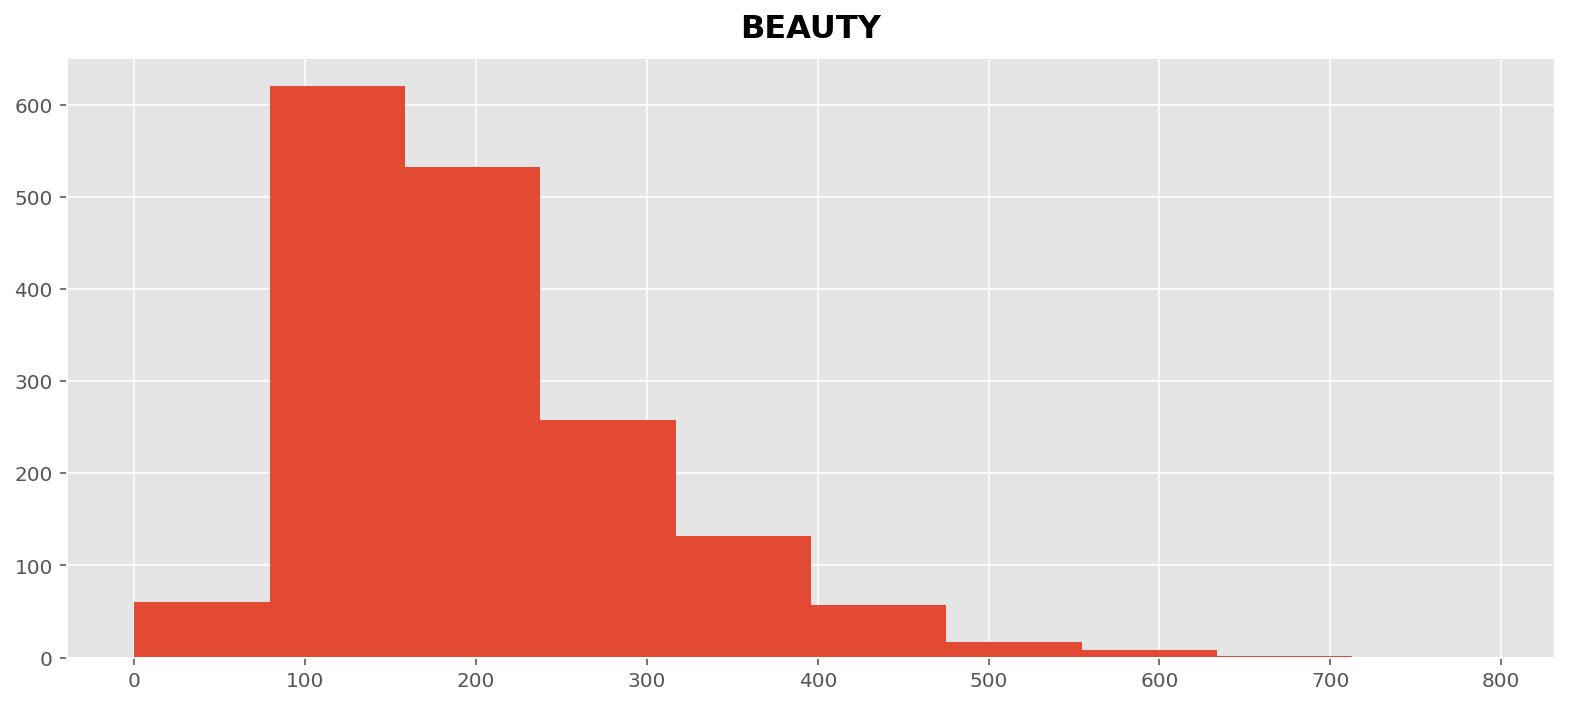

In [168]:
df.hist();

In [169]:
df = np.log(df+1)
df

family,BEAUTY
2013-01-01,1.098612
2013-01-02,5.337538
2013-01-03,4.836282
2013-01-04,4.897840
2013-01-05,5.257495
...,...
2017-08-11,5.863631
2017-08-12,5.913503
2017-08-13,6.073045
2017-08-14,5.823046


In [170]:
df.min()

family
BEAUTY    0.0
dtype: float64

In [174]:
q = np.quantile(df, 0.1)
q

4.561206801507648

In [175]:
df[df<4] = 4

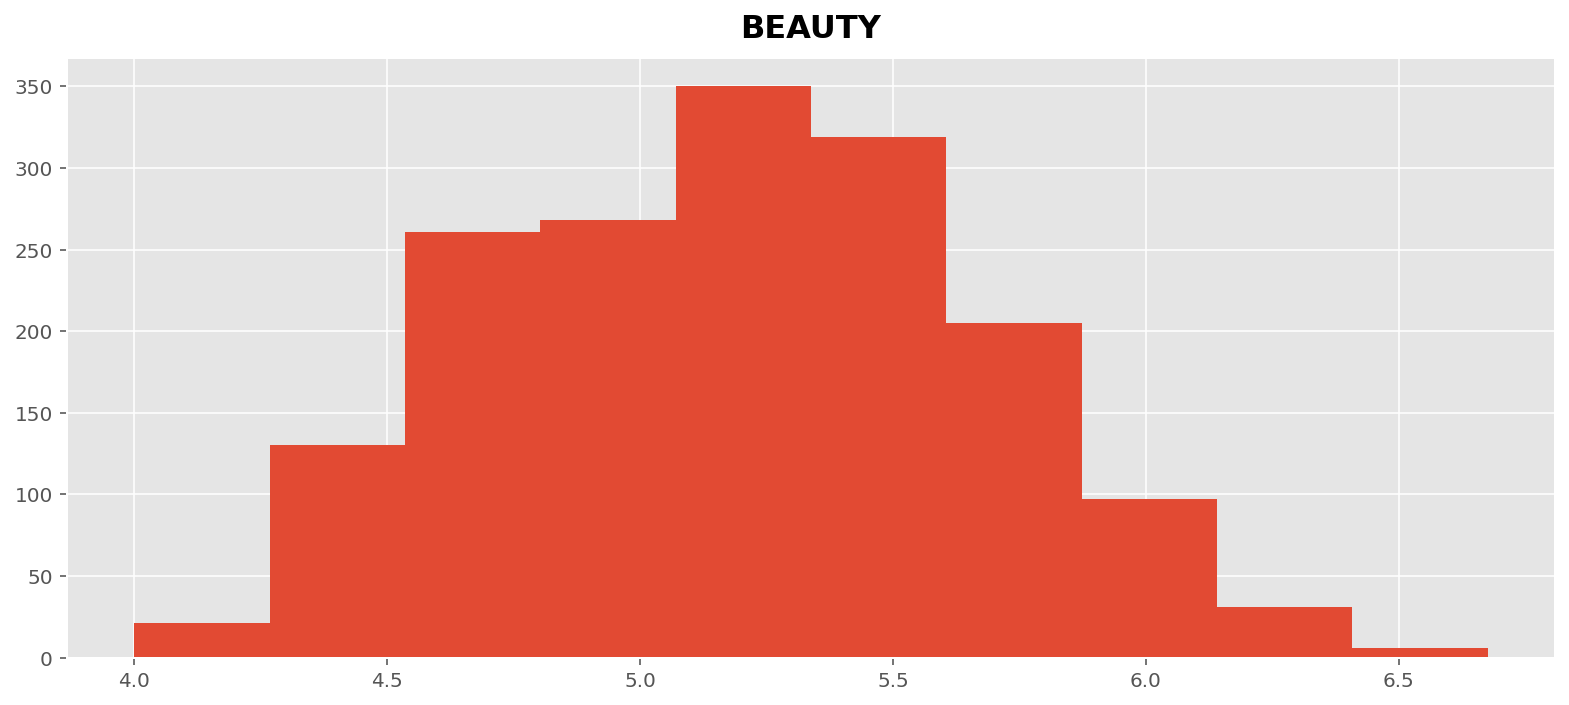

In [176]:
df.hist();

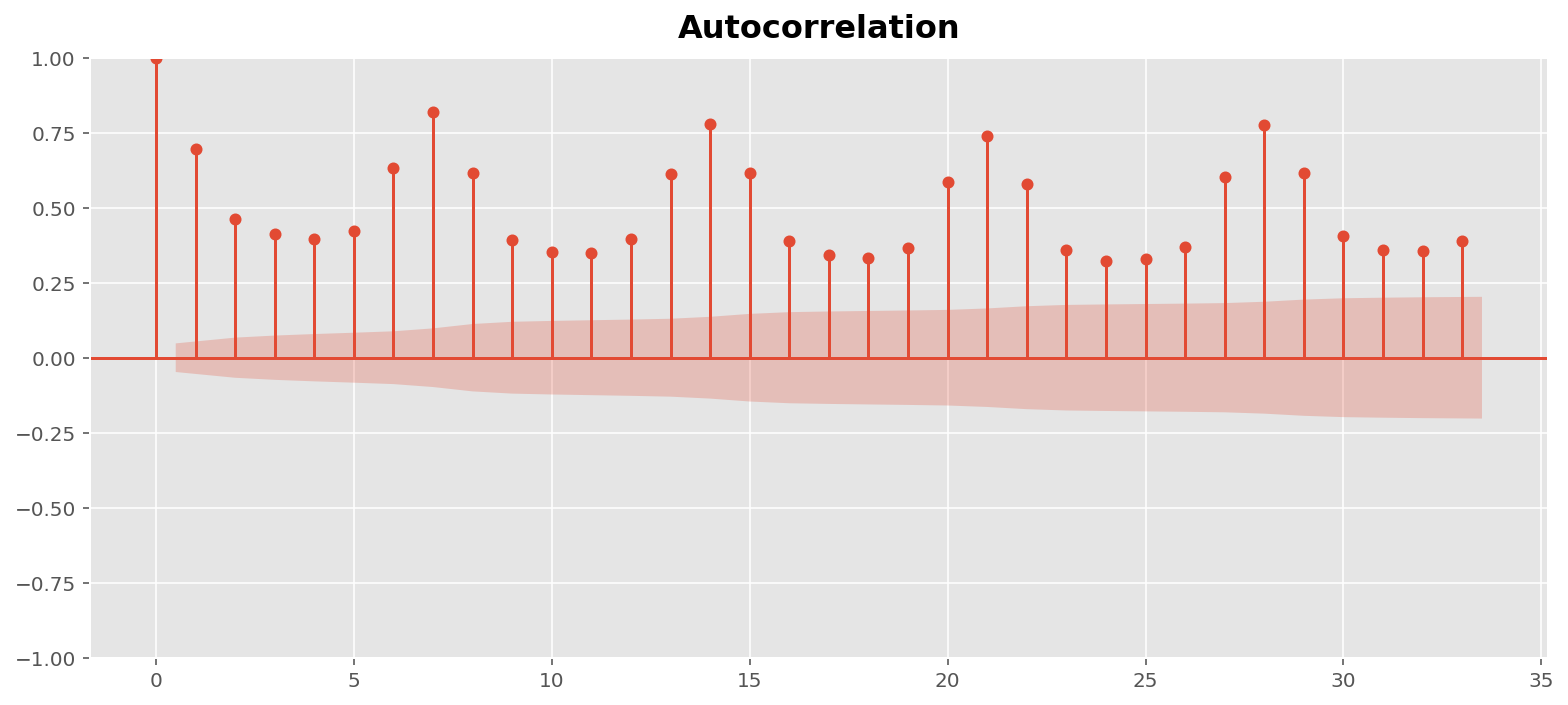

In [177]:
plot_acf(df);

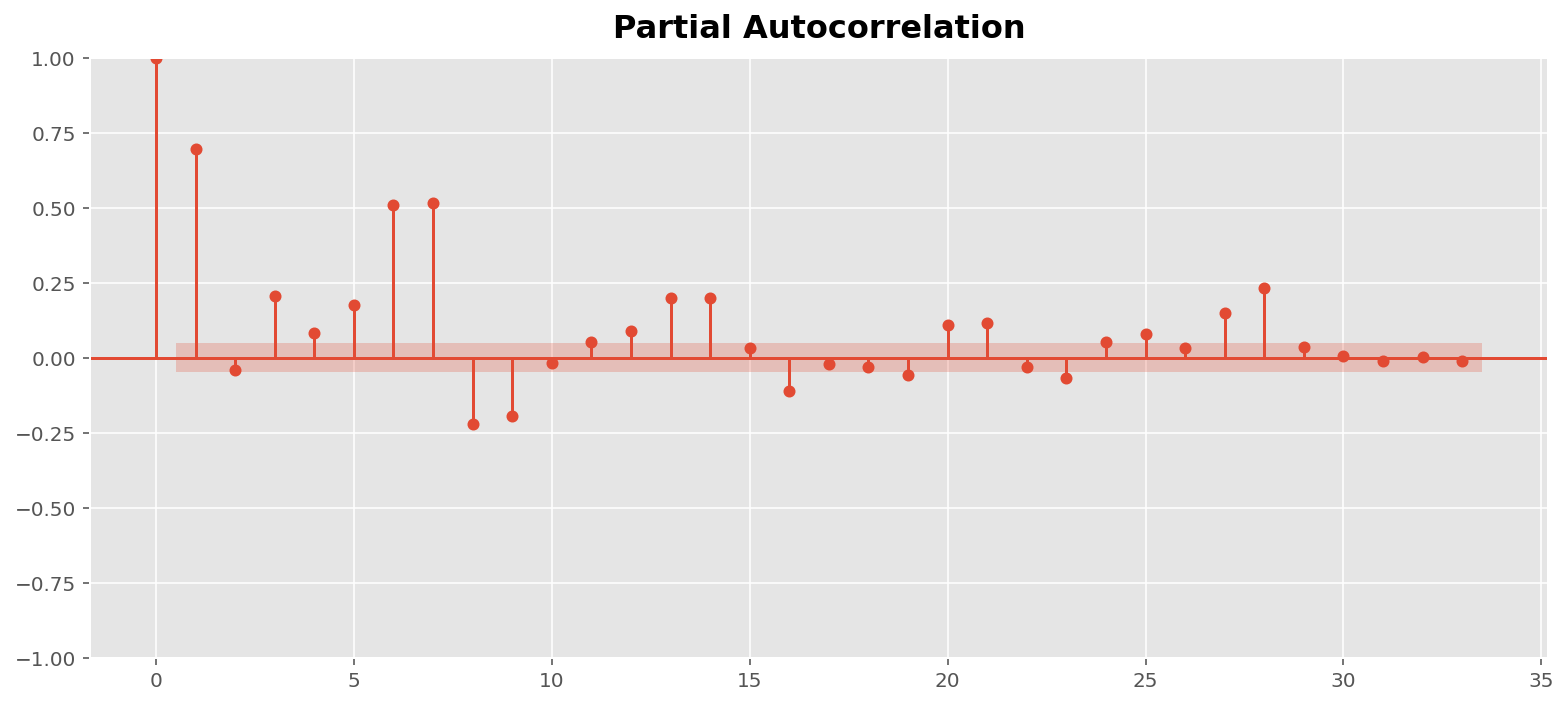

In [178]:
plot_pacf(df);

In [129]:
ss_decomposition = seasonal_decompose(df, period=30)
estimated_obs = ss_decomposition.observed # additive series
estimated_trend = ss_decomposition.trend # upword trend
estimated_seasonal = ss_decomposition.seasonal # weekly seaonality
estimated_residual = ss_decomposition.resid

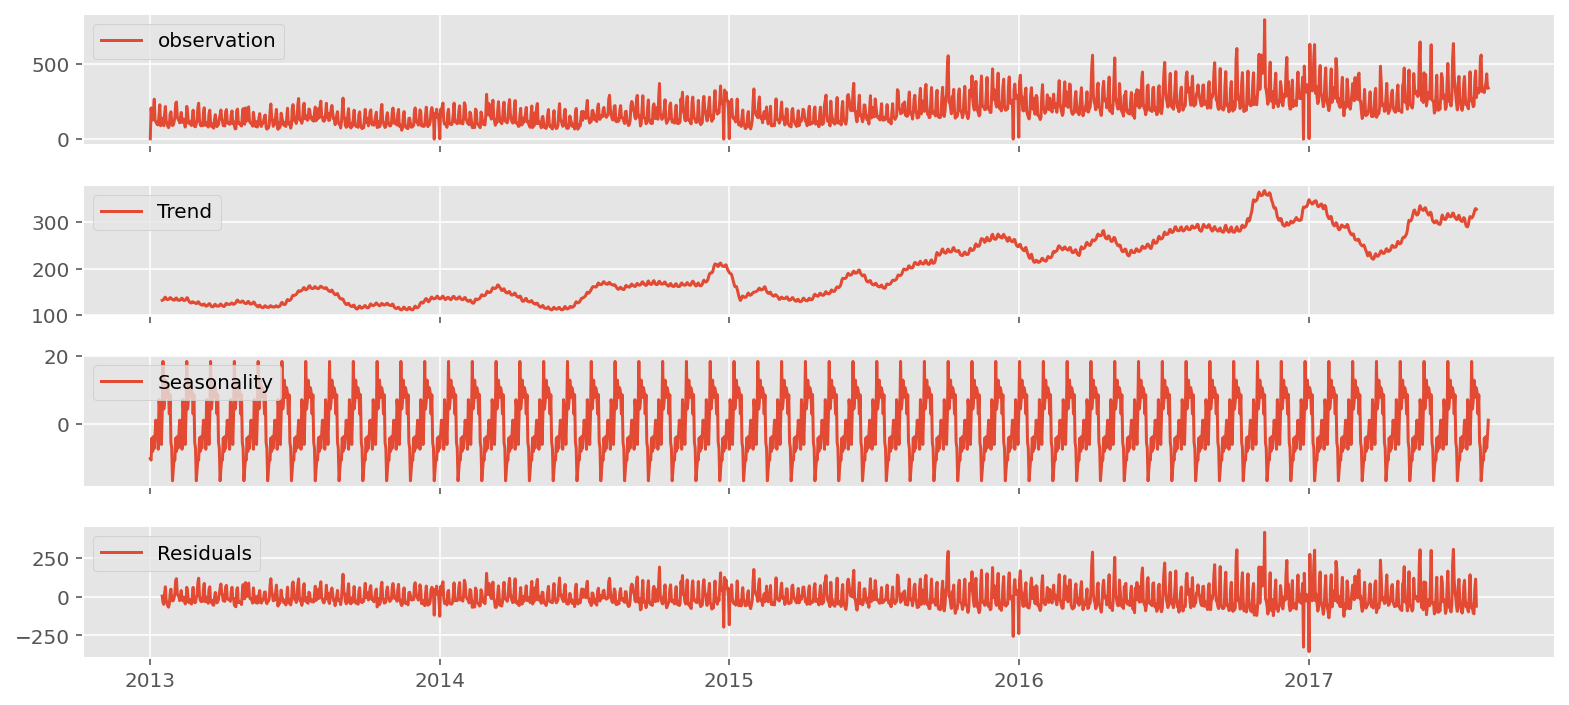

In [130]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)

axes[0].plot(estimated_obs, label='observation')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

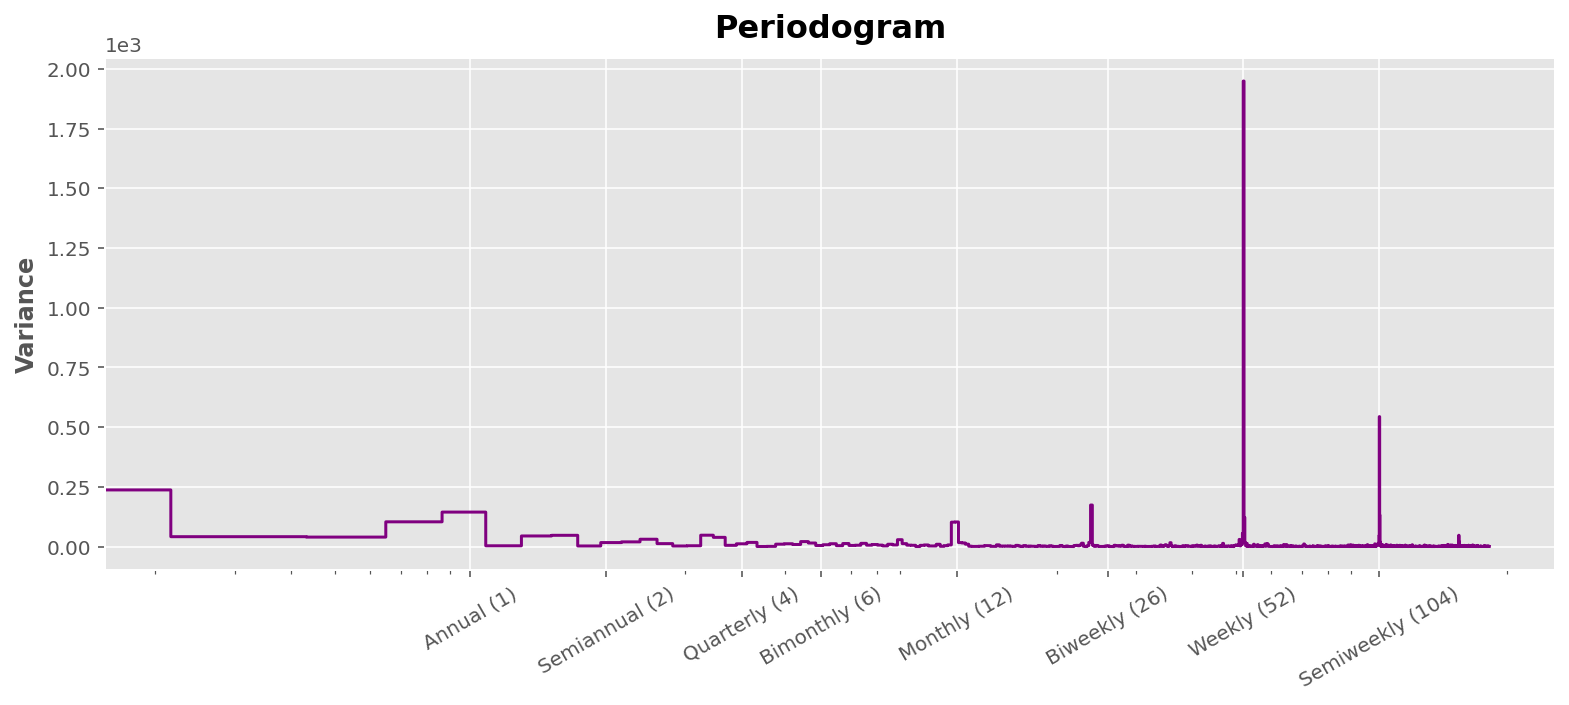

In [32]:
plot_periodogram(df['BEAUTY']); # strong weekly seasonality

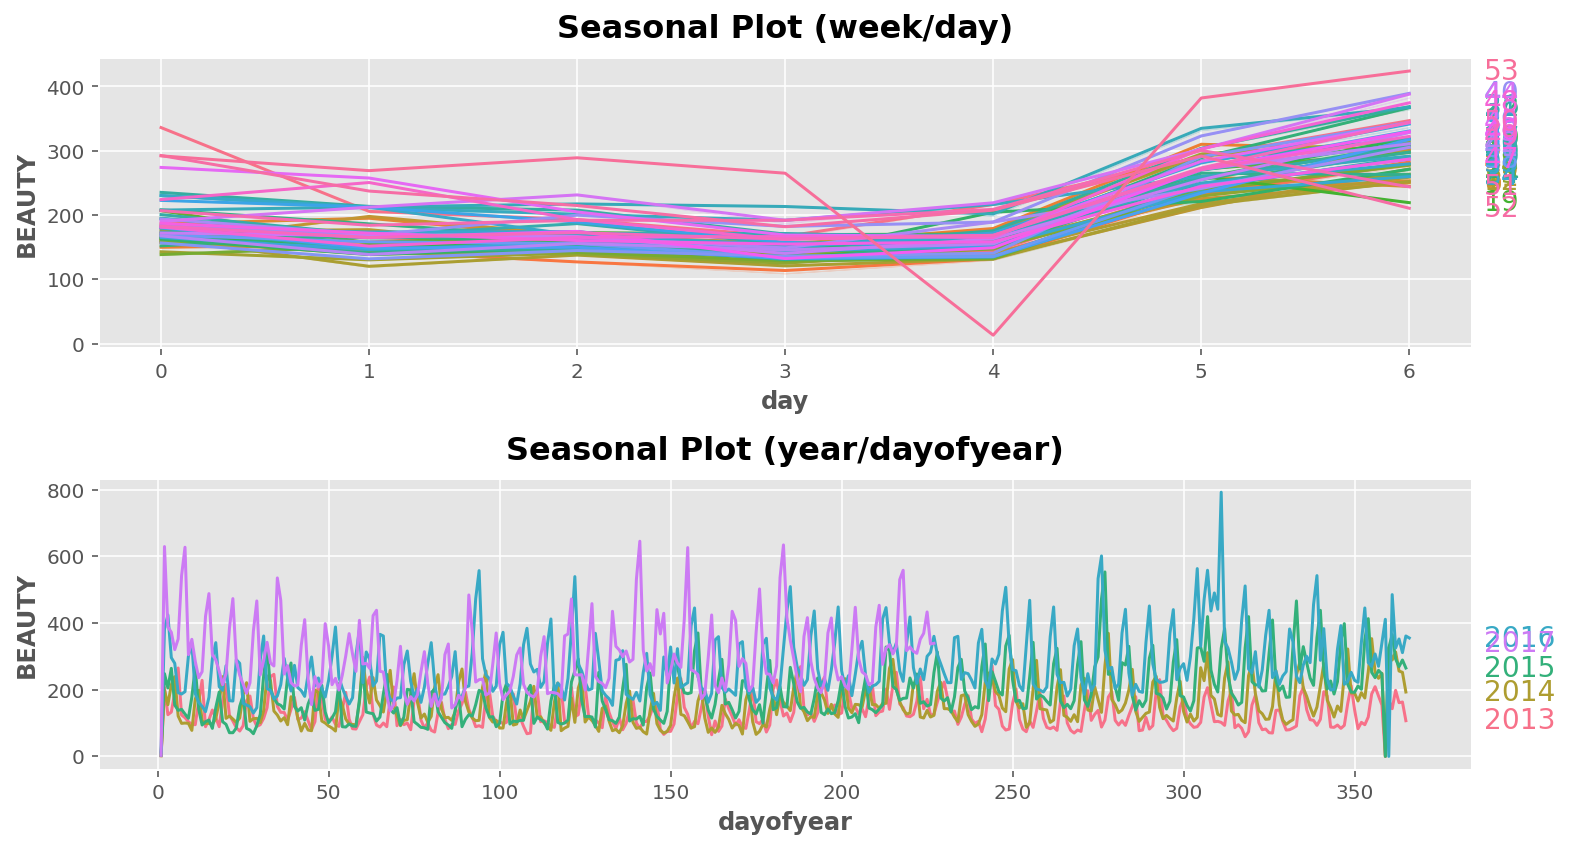

In [33]:
X = df.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="BEAUTY", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="BEAUTY", period="year", freq="dayofyear", ax=ax1);

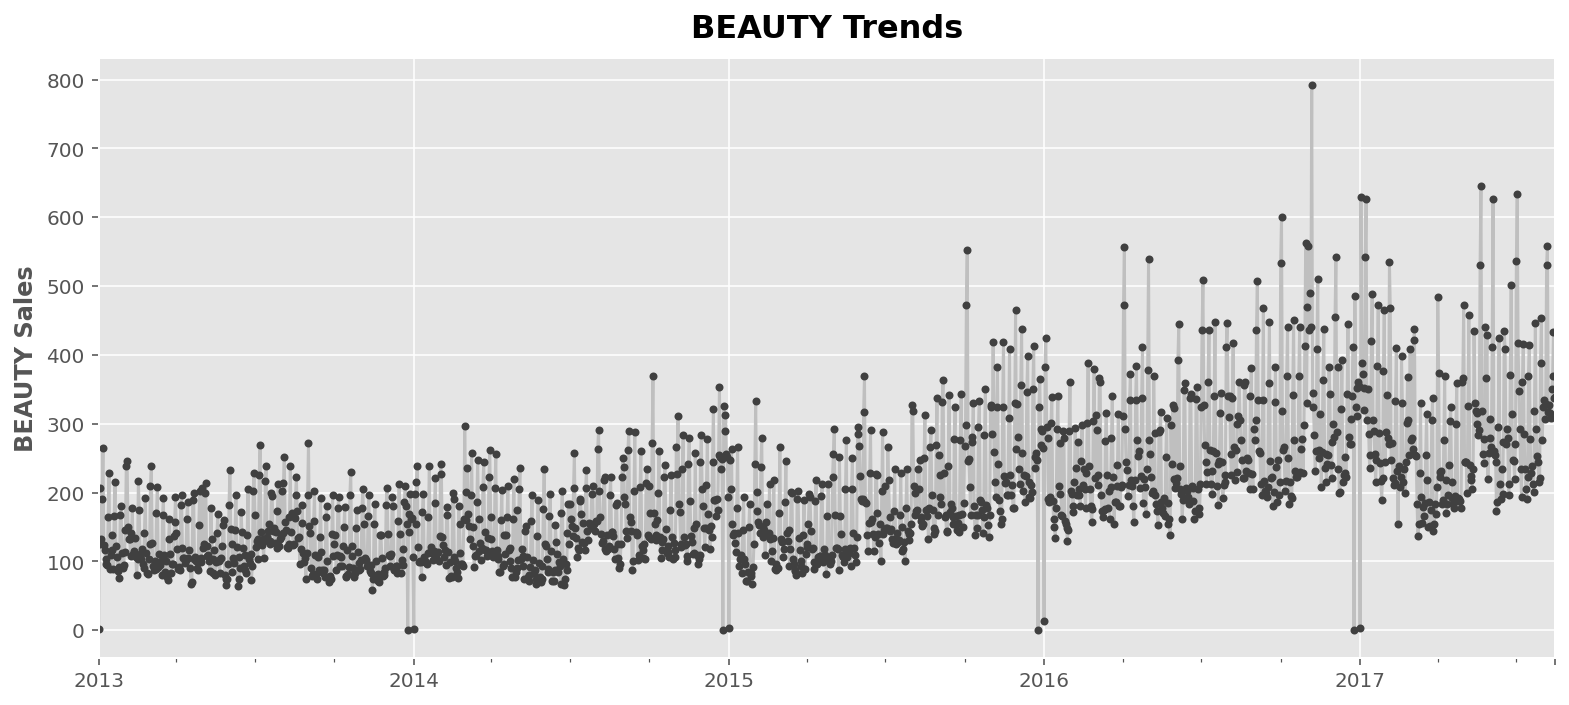

In [34]:
ax = df['BEAUTY'].plot(title='BEAUTY Trends', **plot_params)
_ = ax.set(ylabel="BEAUTY Sales")

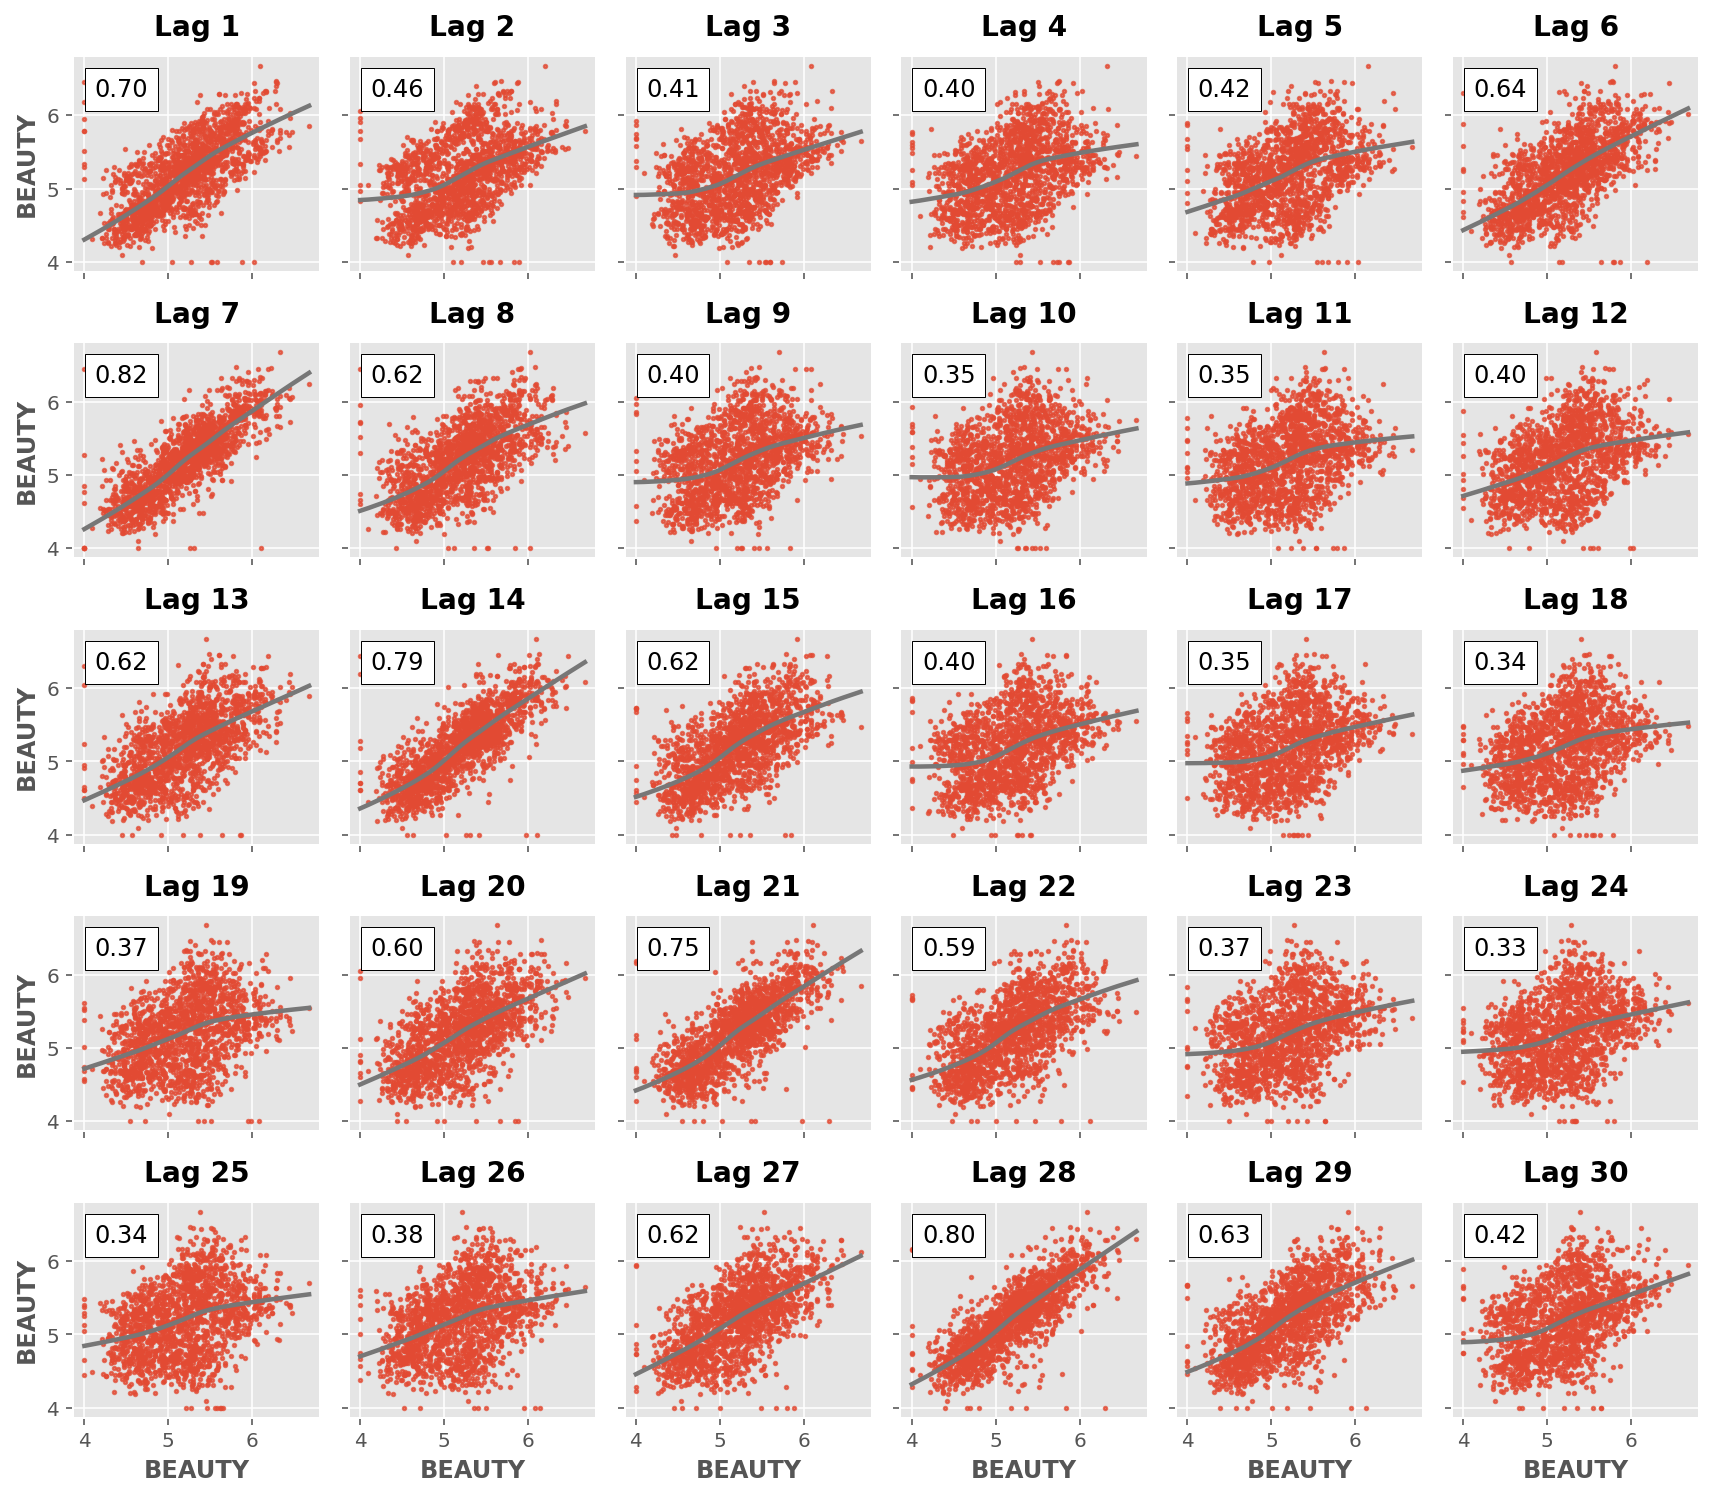

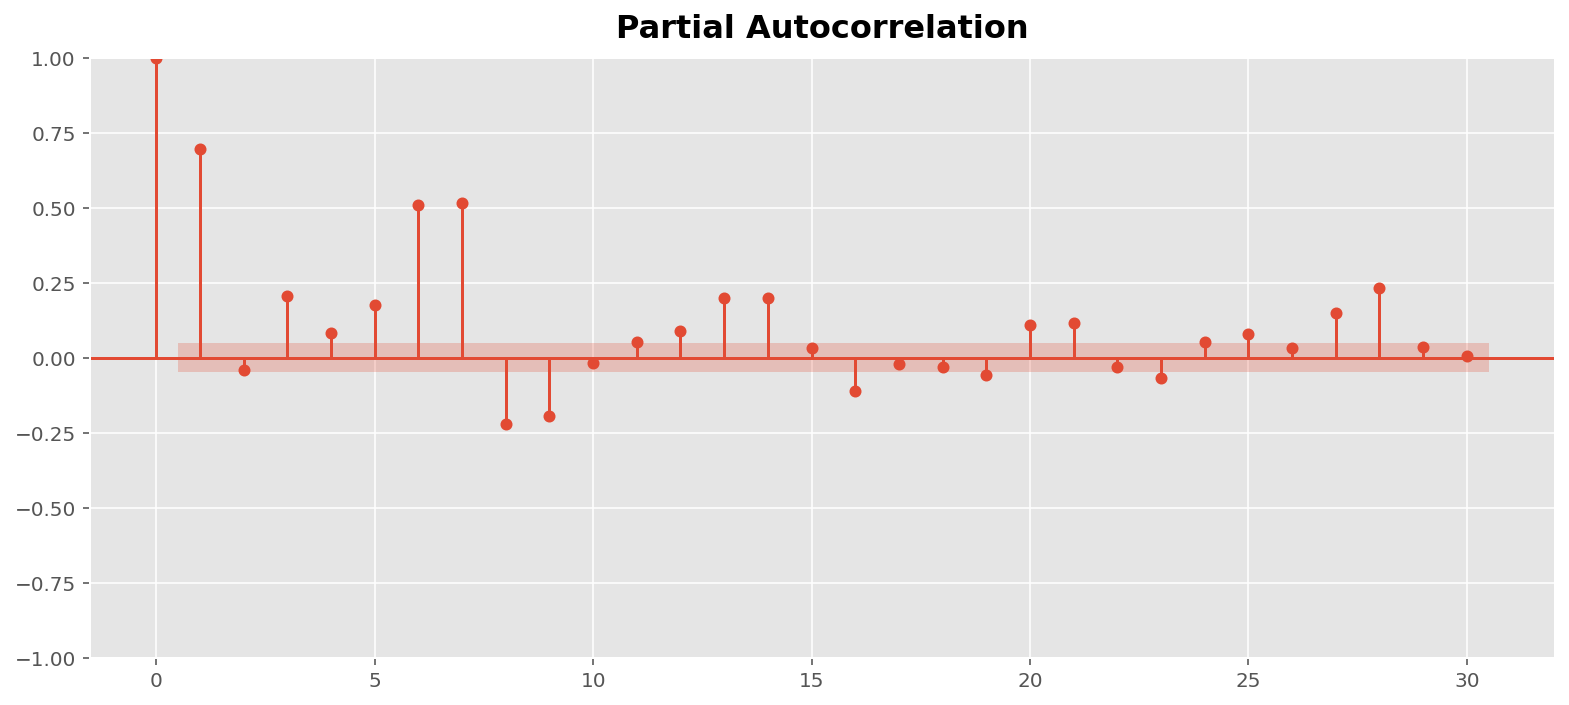

In [179]:
_ = plot_lags(df['BEAUTY'], lags=30, nrows=5)
_ = plot_pacf(df['BEAUTY'], lags=30) # strong lag 1

In [180]:
check = normaltest(df) # nonstationary
check

NormaltestResult(statistic=masked_array(data=[36.43664462819144],
             mask=[False],
       fill_value=1e+20), pvalue=array([1.22428675e-08]))

In [181]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df)

print("ADF: ", adf)
print("p-value:", pvalue) # nonstationary

ADF:  -1.849716339128221
p-value: 0.3560729196591387


In [182]:
df = df.T
df.head()

,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
family,,,,,,,,,,,,,,,,,,,,,
BEAUTY,4.0,5.337538,4.836282,4.89784,5.257495,5.583496,4.828314,4.762174,4.65396,4.574711,...,6.326149,5.762051,5.796058,5.755742,5.736572,5.863631,5.913503,6.073045,5.823046,5.828946


In [194]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=365, y_len=1, test_loops=150)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1173, 365), (150, 365), (1173,), (150,))

In [195]:
# Linear Regression as first model to compare

reg = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(1)), 
                ('LinearRegression', LinearRegression())]) # Create a linear regression object


reg.fit(X_train, y_train) # Fit it to the training data

# Create two predictions for the training and test sets
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Regression')

             MAE  RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Regression                                               
Train       0.12  0.17   0.0     2.28      3.18      0.87
Test        0.16  0.20  -0.1     2.86      3.56      0.63


In [196]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=365, y_len=1, test_loops=0) #use 252 for 1day, 253 for second day

reg = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(1)), 
                ('LinearRegression', LinearRegression())]) # Create a linear regression object

reg.fit(X_train,y_train) # Fit it to the training data

reg_forecast = pd.DataFrame(data=reg.predict(X_test), index=df.index)#, columns=['21-02-2022', '22-02-2022'])
reg_forecast.head()

,0
family,
BEAUTY,6.06073


In [197]:
# use Random Forest with default parameters

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=7, y_len=1, test_loops=150)

forest = Pipeline([('scaler', StandardScaler()), ('Forest', RandomForestRegressor())])

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Forest')

         MAE  RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Forest                                               
Train   0.06  0.08  0.02     1.11      1.60      0.97
Test    0.15  0.21  0.96     2.66      3.66      0.61


In [198]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=7, y_len=1, test_loops=0) #use 252 for 1day, 253 for second day

forest = Pipeline([('scaler', StandardScaler()), ('Forest', RandomForestRegressor())])

forest.fit(X_train,y_train) # Fit it to the training data

forest_forecast = pd.DataFrame(data=forest.predict(X_test), index=df.index)#, columns=['21-02-2022', '22-02-2022'])
forest_forecast.head()

,0
family,
BEAUTY,5.427848


In [199]:
x_len = 7
y_len = 1
n_features = 1

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=x_len, y_len=y_len, test_loops=150)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_train = y_train.reshape(X_train.shape[0], y_len)
y_test = y_test.reshape(X_test.shape[0], y_len)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1531, 7, 1), (150, 7, 1), (1531, 1), (150, 1))

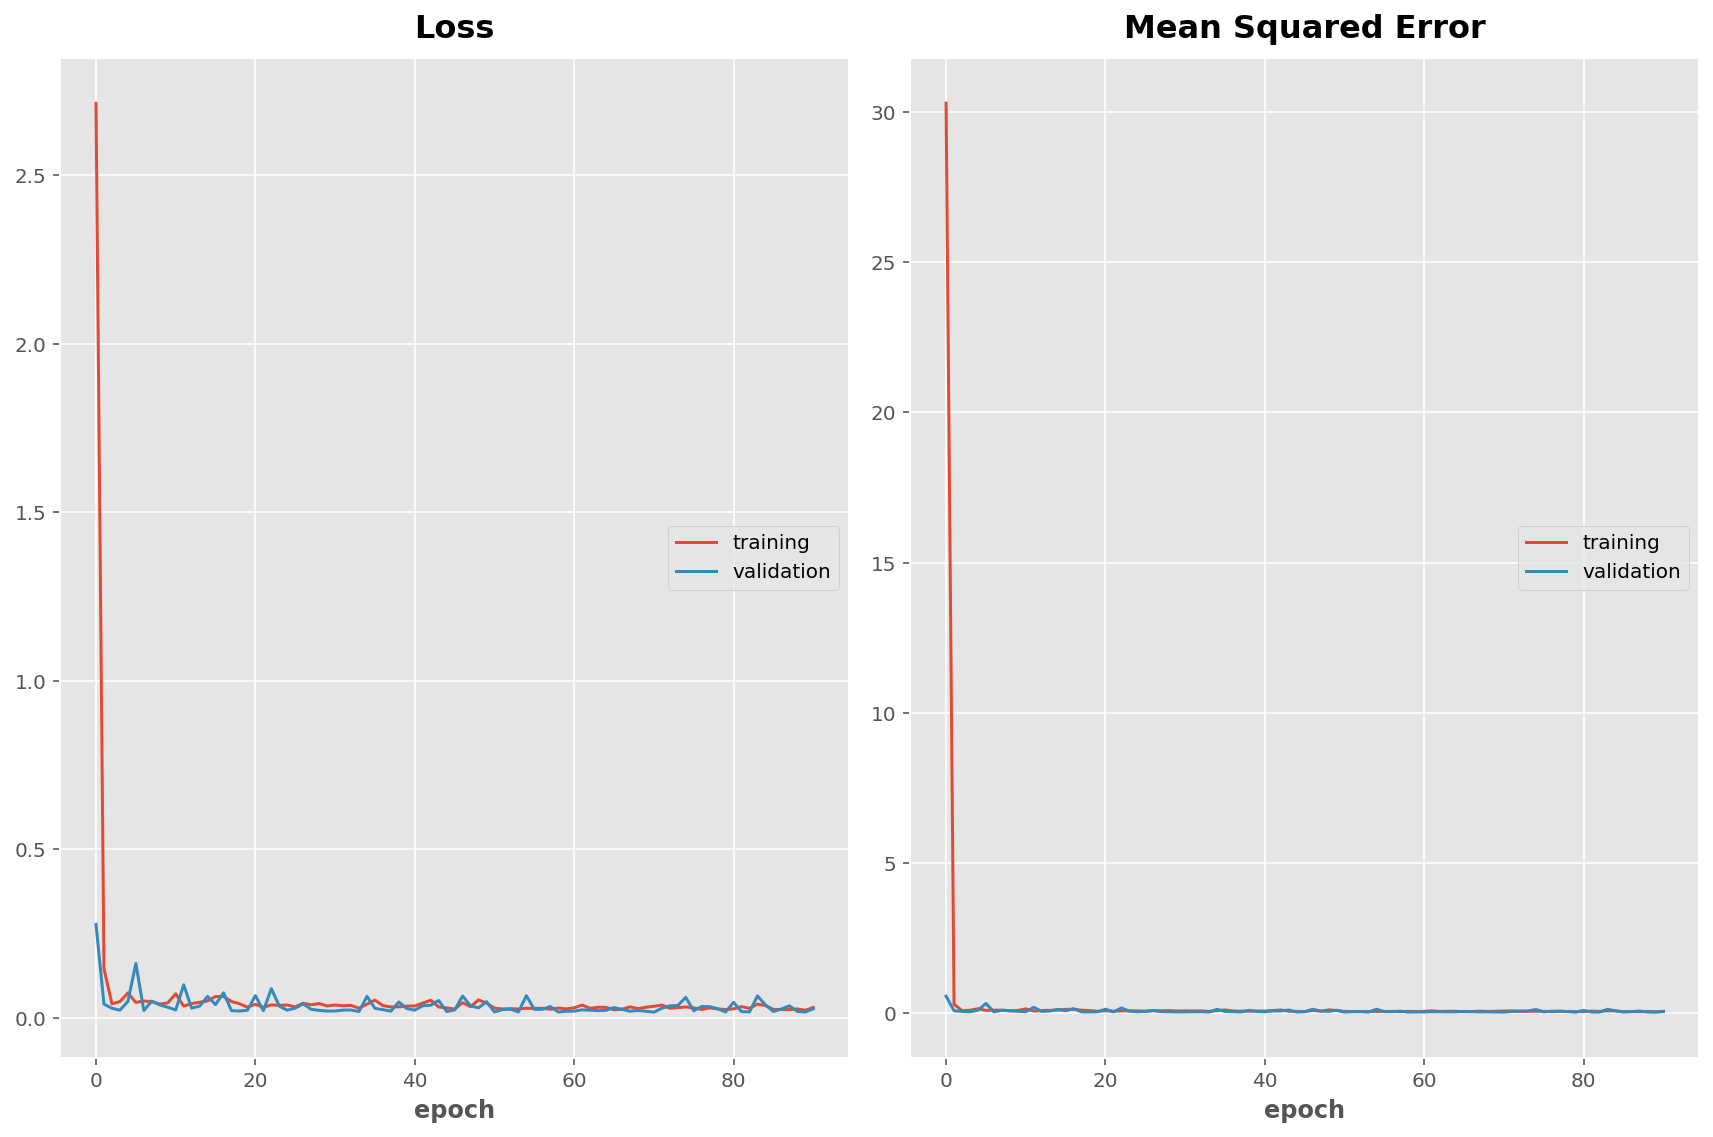

Loss
	training         	 (min:    0.022, max:    2.714, cur:    0.030)
	validation       	 (min:    0.016, max:    0.277, cur:    0.026)
Mean Squared Error
	training         	 (min:    0.045, max:   30.288, cur:    0.061)
	validation       	 (min:    0.033, max:    0.563, cur:    0.053)
48/48 [==============================] - 1s 24ms/step - loss: 0.0301 - mse: 0.0609 - val_loss: 0.0263 - val_mse: 0.0525


In [200]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=96, 
                                                           kernel_size=5, 
                                                           strides=1, 
                                                           padding='causal', 
                                                           activation='relu', 
                                                           input_shape=(x_len, n_features)), 
                                    tf.keras.layers.LSTM(100, return_sequences=True), 
                                    tf.keras.layers.LSTM(100), 
                                    tf.keras.layers.Dense(30), 
                                    tf.keras.layers.Dense(10), 
                                    tf.keras.layers.Dense(y_len),
                                    tf.keras.layers.Lambda(lambda x: x * 400)])


#model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss=tf.keras.losses.Huber() ,optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, 
                    callbacks=[PlotLossesKeras(), callback], verbose=1)

In [201]:
y_train_pred = model.predict(X_train) 
y_test_pred = model.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='LSTM')

        MAE  RMSE  Bias  MAE_pct  RMSE_pct  r2_score
LSTM                                                
Train  0.17  0.22 -0.31     3.21      4.31      0.77
Test   0.17  0.23  2.02     3.02      4.07      0.51


In [202]:
# Forecasting

x_len = 7
y_len = 1
n_features = 1

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=x_len, y_len=y_len, test_loops=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_train = y_train.reshape(X_train.shape[0], y_len)
y_test = y_test.reshape(X_test.shape[0], y_len)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1681, 7, 1), (1, 7, 1), (1681, 1), (1, 1))

In [203]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=96, 
                                                           kernel_size=5, 
                                                           strides=1, 
                                                           padding='causal', 
                                                           activation='relu', 
                                                           input_shape=(x_len, n_features)), 
                                    tf.keras.layers.LSTM(100, return_sequences=True), 
                                    tf.keras.layers.LSTM(100), 
                                    tf.keras.layers.Dense(30), 
                                    tf.keras.layers.Dense(10), 
                                    tf.keras.layers.Dense(y_len),
                                    tf.keras.layers.Lambda(lambda x: x * 400)])


#model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss=tf.keras.losses.Huber() ,optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, epochs=100, verbose=0)

In [204]:
model = pd.DataFrame(data=model.predict(X_test), index=df.index)#, columns=['21-02-2022', '22-02-2022'])
model.head()

,0
family,
BEAUTY,5.438274
